In [15]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import itertools
import matplotlib.pyplot as plt
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from datetime import datetime
import time
import joblib
from joblib import Parallel, delayed

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Neuropixels data. <a name='data'></a>

In [2]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [3]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [30]:
%%time
# Check basic statistics of all probes.
probes = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())
display(selected_units.groupby(['probe_description', 'ecephys_structure_acronym']).last())

# Then select subset of probes.
probes = ['probeA', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
print('final selected probes', probes)

probeC    94
probeE    89
probeA    78
probeD    78
probeB    57
probeF    47
Name: probe_description, dtype: int64

443

,,L_ratio,presence_ratio,isolation_distance,snr,waveform_duration,nn_miss_rate,waveform_recovery_slope,waveform_velocity_below,firing_rate,cluster_id,local_index_unit,waveform_repolarization_slope,waveform_halfwidth,max_drift,waveform_PT_ratio,cumulative_drift,waveform_spread,amplitude_cutoff,d_prime,waveform_amplitude,peak_channel_id,silhouette_score,nn_hit_rate,waveform_velocity_above,isi_violations,c50_dg,area_rf,fano_dg,fano_fl,fano_ns,fano_rf,fano_sg,f1_f0_dg,g_dsi_dg,g_osi_dg,g_osi_sg,azimuth_rf,mod_idx_dg,p_value_rf,pref_sf_sg,pref_tf_dg,run_mod_dg,run_mod_fl,run_mod_ns,run_mod_rf,run_mod_sg,pref_ori_dg,pref_ori_sg,run_pval_dg,run_pval_fl,run_pval_ns,run_pval_rf,run_pval_sg,elevation_rf,pref_image_ns,pref_phase_sg,firing_rate_dg,firing_rate_fl,firing_rate_ns,firing_rate_rf,firing_rate_sg,on_off_ratio_fl,time_to_peak_ns,pref_sf_multi_sg,pref_tf_multi_dg,pref_ori_multi_dg,pref_ori_multi_sg,pref_phase_multi_sg,image_selectivity_ns,pref_image_multi_ns,lifetime_sparseness_dg,lifetime_sparseness_fl,lifetime_sparseness_ns,lifetime_sparseness_rf,lifetime_sparseness_sg,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
probe_description,ecephys_structure_acronym,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
probeA,VISam,0.015568,0.99,56.873778,2.217387,0.714238,0.004750,-0.015566,0.755444,2.330244,392,385,0.182642,0.247236,40.75,0.374745,459.38,50.0,0.022298,4.275154,64.803765,849855994,0.125534,0.963333,2.060302,0.125646,0.060341,700.0,3.257075,0.826667,0.756547,1.308333,0.322535,0.342330,0.025033,0.340267,0.625045,82.857,1.248681,0.000,0.04,1.0,0.027656,0.618182,0.309144,0.611111,0.180976,0.0,0.0,0.876909,0.082969,0.000228,0.216980,7.776317e-04,10.000,4992,0.00,3.965416,0.586179,2.079605,0.878294,5.096403,NaN,0.1165,False,False,False,False,False,0.830508,False,0.488876,0.064000,0.695607,0.460287,0.631725,2700,11,800036196,269,394.0,7613.0,481.0,7559.0,See electrode locations,29999.965974,1249.998582,True
probeB,VISam,0.009419,0.99,535.883528,2.231816,0.233501,0.054688,-0.034283,0.327032,17.989545,287,279,0.239873,0.178559,25.63,0.191810,182.65,90.0,0.009865,4.790931,53.481090,849854722,0.101824,0.997333,0.686767,0.012760,0.124518,300.0,1.427952,1.081905,0.741379,0.708527,1.058712,0.182809,0.045579,0.082039,0.072583,40.000,0.740204,0.000,0.04,2.0,0.140547,0.409060,0.221643,0.305556,0.092159,0.0,150.0,0.007933,0.000027,0.001777,0.035865,3.235461e-01,50.000,4992,0.00,18.205227,18.144899,20.948526,8.370656,24.441554,NaN,0.1225,False,False,False,False,False,0.272542,False,0.021480,0.001556,0.031615,0.167023,0.025828,2560,27,800036198,255,394.0,7943.0,476.0,7422.0,See electrode locations,29999.917201,1249.996550,True
probeC,VISp,0.042912,0.99,37.973009,1.832974,0.755444,0.006829,-0.018379,0.686767,1.047711,420,400,0.131790,0.247236,35.20,0.487796,427.14,60.0,0.021331,2.867965,50.750505,849853312,0.079066,0.575630,1.030151,0.294413,1.065773,900.0,3.230108,1.253333,1.165714,1.911111,0.940000,0.929324,0.091061,0.228532,0.396523,44.444,4.818274,0.000,0.32,2.0,-0.135593,-0.684783,0.570520,-1.000000,0.558036,0.0,0.0,0.693759,0.286903,0.005894,0.009152,2.096170e-04,14.444,4984,0.25,0.822312,0.186511,1.217805,0.678731,1.402826,NaN,0.0915,False,False,False,False,False,0.504254,False,0.373882,0.675676,0.320768,0.586041,0.418974,2360,59,800036200,234,385.0,9130.0,827.0,8239.0,See electrode locations,29999.996048,1249.999835,True
probeD,VISl,0.014502,0.99,56.397459,2.002475,1.263652,0.000921,-0.065126,0.206030,1.574157,393,377,0.010473,0.192295,23.77,13.146540,232.75,60.0,0.010090,5.281608,51.905490,849851976,0.171867,0.962000,0.000000,0.202876,0.565196,300.0,3.110256,0.911667,0.628213,3.533333,1.270639,1.575176,0.294153,0.941154,0.674843,13.333,0.096218,0.007,0.08,1.0,0.676190,0.278997,0.238298,0

final selected probes ['probeA', 'probeC', 'probeD', 'probeE', 'probeF']
Wall time: 90.8 ms


#### Fine Time Coupling Model

In [5]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
jittertool = jitter.JitterTool()

## Trials Selection

In [6]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261, 278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261, 286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989
# condition_ids = [270, 274, 249, 265, 261, 286, 258, 278, 280, 260, 257], all 4, 8 Hz

In [31]:
condition_ids = [270, 274, 249, 265, 261, 286, 258, 278, 280, 260, 257]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
1  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
2  258 temp freq [4.0] orient [225.0] contrast [0.8] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
3  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
4  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275 49313 49407]
5  265 temp freq [4.0] orient [135.0] contrast [0.8] [ 3824  3848  3880  3920  3953  3955  3960  3968  3973  3992 31039 31093 49232 49339 49383]
6  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 

## Spike Trains

In [7]:
%%time
trial_window = [0.4, 2.0]

# dt=0.002
# spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_window,
        metric_type='spike_times')


Wall time: 5min 22s


In [8]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(443, 285)

# Fit individual filter + raw filter clustering.

In [32]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(None, spike_times, selected_units, trials_groups, trial_window,
                   probes=['probeA', 'probeC', 'probeD', 'probeE', 'probeF'], num_areas=6, verbose=False)

conditions: [(0, 249), (1, 257), (2, 258), (3, 260), (4, 261), (5, 265), (6, 270), (7, 274), (8, 278), (9, 280), (10, 286)]


In [33]:
select_condition_ids = condition_ids

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(select_condition_ids)]
selected_trial_ids = trials_df.index.values
print(selected_trial_ids)

[ 3801  3810  3813  3814  3816  3817  3822  3824  3826  3828  3835  3844  3848  3862  3866  3870  3872  3875
  3876  3878  3880  3888  3895  3897  3898  3900  3905  3911  3914  3920  3922  3925  3928  3930  3932  3933
  3934  3936  3937  3943  3946  3948  3949  3953  3955  3956  3960  3962  3964  3967  3968  3973  3980  3984
  3986  3987  3992  3996  3997 31002 31020 31021 31022 31027 31028 31033 31039 31043 31046 31053 31054 31055
 31062 31064 31075 31080 31093 31096 31104 31114 31129 31142 31148 31151 31152 31154 31156 31159 31161 31162
 31165 31167 31171 31173 31174 31175 31177 31178 31182 31184 31185 31187 31188 31190 31194 31196 31199 49211
 49215 49217 49225 49226 49228 49230 49232 49240 49250 49251 49254 49257 49263 49266 49268 49274 49275 49280
 49281 49282 49286 49290 49304 49307 49313 49317 49320 49322 49328 49332 49339 49340 49341 49349 49361 49364
 49365 49367 49368 49370 49374 49383 49390 49395 49400 49401 49405 49407 49410 49411 49414 49415 49418 49420
 49422 49428 49430]

### Between probes.

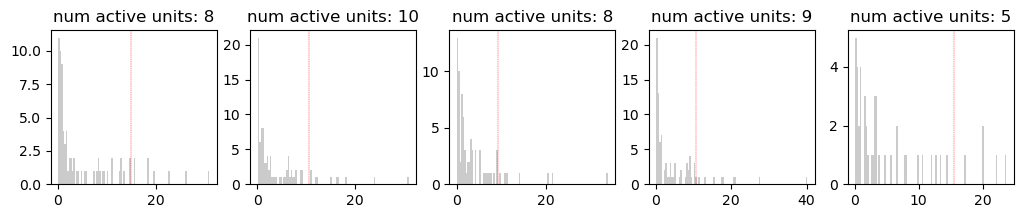

In [34]:
active_firing_rate_quantile_threshold = 0.9
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)


('probeA', 'probeC')
area paris [('probeA', 'probeC')]
num_pairs: 80
100%|███████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.17s/it]
optimal kernel width  85.0


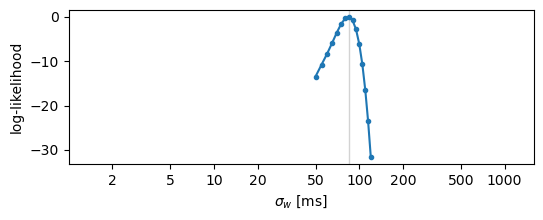

100%|███████████████████████████████████████████████████████████████| 80/80 [00:59<00:00,  1.34it/s]
num_models 80


TypeError: 'itertools.permutations' object is not subscriptable

In [35]:
probe_pairs = itertools.permutations(['probeA', 'probeC', 'probeD', 'probeE', 'probeF'], 2)

for probe_pair in probe_pairs:

    print(probe_pair)
    neuron_pairs = model.construct_unit_pairs(active_units, pair_type='between_probe', probe_pairs=[probe_pair], verbose=True)
    filter_membership = model.init_filter_membership(neuron_pairs, trial_ids=selected_trial_ids, random_val=True)

    # Kernel selection.
    kernel_width_grid = np.arange(50, 125, 5) / 1000
    _,_,optimal_kernel_width = model.estimate_nuisance_kernel_width_together(filter_membership, batch_size=2000, kernel_width_grid=kernel_width_grid)

    # Model fitting.
    # model_par = {'filter_type': 'bspline', 'num_knots': 8, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1,
    #              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
    #              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

    model_par = {'filter_type': 'square', 'filter_length': 0.04,
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': optimal_kernel_width,
                 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 60, 'epsilon': 1e-5}

    model_list = model.pairwise_bivariate_regression(filter_membership, model_par, verbose=False)
    # model_list = model.pairwise_bivariate_regression(filter_membership, model_par, verbose=False, parallel=True, num_threads=6)

    print('num_models', len(model_list))
    timestamp = datetime.now().strftime('%d_%m_%Y_%H%M%S')
    model_file = project_dir + f'Output/jitter/coupling_network/session{session_id}_model_list_{probe_pair[0]}_to_{probe_pair[1]}_{timestamp}.pkl'
    util.save_variable(model_file, model_list)

    break

In [38]:
df_inference = pd.DataFrame(index=filter_membership.index)
df_inference.index.names = ['source', 'target']

for m, (neuron_pair, model_par) in enumerate(model_list):
    pval = jittertool.bivariate_continuous_time_coupling_filter_regression_inference_single(model_par)
    df_inference.loc[neuron_pair, 'pval'] = pval
    num_nuisance = len(model_par['append_nuisance'])
    df_inference.loc[neuron_pair, 'h'] = model_par['beta'][num_nuisance,0]

# display(df_inference)
# display(df_inference[df_inference.pval<1e-4])
df_inference = df_inference.reset_index()
df_inference = pd.merge(df_inference, selected_units[['probe_description']], left_on='source', right_on='unit_id')
df_inference = df_inference.rename(columns={'probe_description': 'source_probe'})
df_inference = pd.merge(df_inference, selected_units[['probe_description']], left_on='target', right_on='unit_id')
df_inference = df_inference.rename(columns={'probe_description': 'target_probe'})

df_inference = pd.merge(df_inference, selected_units[['ecephys_structure_acronym']], left_on='source', right_on='unit_id')
df_inference = df_inference.rename(columns={'ecephys_structure_acronym': 'source_area'})
df_inference = pd.merge(df_inference, selected_units[['ecephys_structure_acronym']], left_on='target', right_on='unit_id')
df_inference = df_inference.rename(columns={'ecephys_structure_acronym': 'target_area'})

df_inference = df_inference.set_index(['source','target'])
df_inference

timestamp = datetime.now().strftime('%d_%m_%Y_%H%M%S')
output_file = project_dir + f'Output/jitter/coupling_network/session{session_id}_df_inference_{probe_pair[0]}_to_{probe_pair[1]}_{timestamp}.parquet'
df_inference.to_parquet(output_file)

### Plot significant edges

In [ ]:
# load all df_inference.
import glob
inference_dir = project_dir + 'Output/jitter/coupling_network/'
files = glob.glob(inference_dir + f'session{session_id}_df_inference_*.parquet')

df_inference_all = []
for f in files:
    dfx = pd.read_parquet(f)
    df_inference_all.append(dfx)
    
df_inference_all = pd.concat(df_inference_all, axis=0)
df_inference_all

In [22]:
from statsmodels.stats.multitest import multipletests

test_outcome = multipletests(df_inference.pval.values.reshape(-1), alpha=0.01, method='bonferroni')  # fdr_by, bonferroni
df_inference['significant'] = test_outcome[0]
print('adjusted p-value threshod', test_outcome[2])
df_inference.significant.value_counts()


adjusted p-value threshod 0.00020936007806748869


False    28
True     20
Name: significant, dtype: int64

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/between_probe_network.pdf


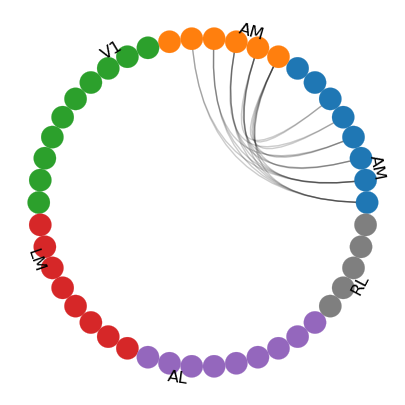

In [23]:
layout_units = active_units
figure_path = project_dir + 'Output/fig/between_probe_network.pdf'
model.build_graph_from_regression_pval(df_inference, layout_units=layout_units, figure_path=figure_path)

# KS test

In [ ]:
u_list_dict = model.ks_test(spike_times, trial_window, group_model_pars, filter_membership_CD, selected_trial_ids, verbose=False)


In [2007]:
file_path = model_dir + f'CD_ks_test_u_list_dict_x3_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
util.save_variable(file_path, u_list_dict)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/CD_ks_test_u_list_dict_x3_20211123_213246.pkl


#### Plot all KS plots together.

In [2100]:
model_dir = project_dir + 'Output/jitter/coupling_filter/CD_DE_condition19_joint_fit_fixed_portion_11122021/'
# file_path = model_dir + 'CD_ks_test_u_list_dict_x3_20211123_213246.pkl'
file_path = model_dir + 'CD_ks_test_u_list_dict_20211123_144356.pkl'
u_list_dict_0 = util.load_variable(file_path)
file_path = model_dir + 'DE_ks_test_u_list_dict_20211123_192039.pkl'
u_list_dict_1 = util.load_variable(file_path)
u_list_dict = z = {**u_list_dict_0, **u_list_dict_1}

save figure: D:/Brain_Network/Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf


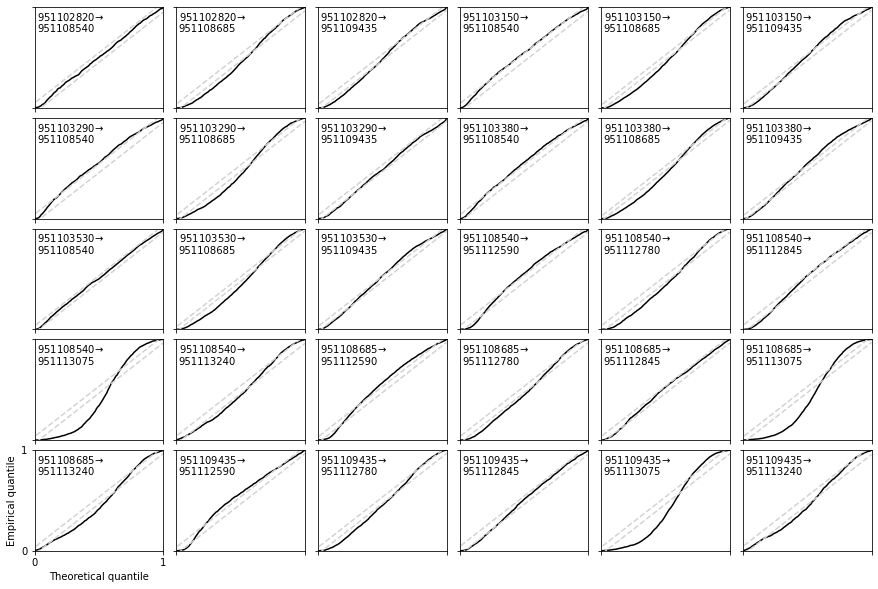

In [2102]:
file_path = project_dir + 'Output/fig/CD_DE_condition19_joint_fit_fixed_portion_11122021_KS.pdf'
model.plot_ks_u_list_dict(u_list_dict, test_size=0.01, file_path=file_path)

In [ ]:
u_list = u_list_dict[(951108685, 951108867)]
u_list = u_list[u_list > 0]
CI_trap, mcdf, ecdf, CI_up, CI_dn = jitter.JitterTool.check_ks(u_list, test_size=0.01, bin_width=0.02, verbose=True)

##### Debugging some errors.  951113075, 951113175 are weird. only one exception.
951109435 951113075

951108685 951113075

951108540 951113075

layers 2, nodes 1, trials 285
meanFR 27.144	meanISI 34.62


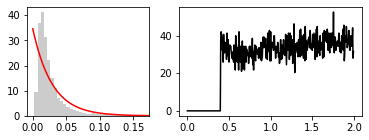

layers 2, nodes 1, trials 285
meanFR 7.358	meanISI 12.33


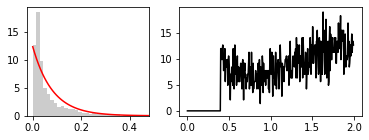

In [241]:
spike_times_x = spike_times.loc[951109319,:].tolist()
spike_times_y = spike_times.loc[951113717,:].tolist()
trial_length = trial_window[1]
jittertool.spike_times_statistics(spike_times_x, trial_length, verbose=True)
jittertool.spike_times_statistics(spike_times_y, trial_length, verbose=True)

num_trials 285
X.shape (4194, 3), basis_integral.shape (3, 1),beta.shape(3, 1)
  9%|█████▍                                                       | 9/100 [00:00<00:00, 1817.20it/s]
gradient [-3.23432971e-05 -5.28686735e-05 -6.55810746e-06]
num itr 9 [[-6215.64457553]] 4.6153603358578543e-07
beta [ 6.89122802  0.75076046 -0.10736803]


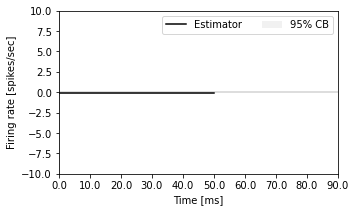

In [242]:
model_par = {'filter_type': 'square', 'filter_length': 0.05,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.075,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

# model_par = {'filter_type': 'none',
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.08,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-7}

# model_par = {'filter_type': 'none',
#              'append_nuisance': ['const',],
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

# model_par = {'filter_type': 'bspline', 'num_knots': 5, 'knot_space_par': 0.1, 'filter_length': 0.4, 'num_tail_drop': 1,
#              'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.06,
#              'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
    spike_times_x[:], spike_times_y[:], [0, trial_length], model_par, verbose=True)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, ylim=[-10,10])

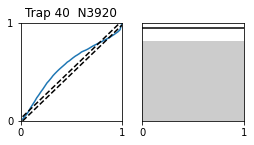

In [243]:
model_par_ks_test = jittertool.ks_test(spike_times_x, spike_times_y, trial_window, model_par_hat, dt=0.001, test_size=0.05, verbose=True)
